In [1]:
import pandas as pd
import numpy as np
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
import matplotlib.ticker as ticker
import seaborn as sns
import dataframe_image as dfi
from pandas.io.formats.style import Styler
import imgkit
from functools import reduce
import pystout

In [2]:
# reading in raw counts for manual checking DEGs
raw_counts = pd.read_csv("all_identified_predicted_RNAs.csv", sep ="\t", index_col=0)

In [3]:
# Reading in DERs
DERs_inf_cur = pd.read_csv("../DERNAs_inf_vs_cured.csv", index_col=0, sep="\t")
DERs_unf_cur = pd.read_csv("../DERNAs_unf_vs_cured.csv", index_col=0, sep="\t")
wol_mapped_ids = list(pd.read_csv("../DEGs_vs_Wolbachia/masked_Wol_mapped_ids.txt", header=None)[0])
wol_mapped_ids = [i.strip() for i in wol_mapped_ids]
sig_inf_cur = DERs_inf_cur[(abs(DERs_inf_cur["log2FoldChange"]) > 2) & (DERs_inf_cur["padj"] < 0.05)]
sig_unf_cur = DERs_unf_cur[(abs(DERs_unf_cur["log2FoldChange"]) > 2) & (DERs_unf_cur["padj"] < 0.05)]
noise = list(sig_unf_cur.index)
mask = sig_inf_cur.index.isin(noise)
removed_noise = sig_inf_cur.loc[~mask]

In [4]:
# Copy this string in to piRBase to get the sequences
piRNAs_known = (",".join(removed_noise.index[removed_noise.index.str.contains("piR-")]))
# Use url to get table with known piRNAs
known_piRNA_Seqs = pd.read_html('http://bigdata.ibp.ac.cn/piRBase/searchResultTable.php?search_string=piR-dme-62476,piR-dme-155190,piR-dme-333803,piR-dme-742047,piR-dme-4435825,piR-dme-4868465,piR-dme-4933247,piR-dme-5162988,piR-dme-6001070,piR-dme-6258388,piR-dme-6499079,piR-dme-6510341,piR-dme-7555326,piR-dme-8772583,piR-dme-10714862,piR-dme-11343739,piR-dme-11351147,piR-dme-11463543,piR-dme-11543932,piR-dme-11772859,piR-dme-12199247,piR-dme-12293325,piR-dme-12294433,piR-dme-12410583,piR-dme-12585108,piR-dme-13702518,piR-dme-13800276,piR-dme-14195470,piR-dme-14587819,piR-dme-22049675,piR-dme-22161618,piR-dme-22210926,piR-dme-32337310,piR-dme-32372836,piR-dme-32579322,piR-dme-32758534,piR-dme-32825368,piR-dme-32923393,piR-dme-33393023,piR-dme-33435007,piR-dme-33556300,piR-dme-33608579,piR-dme-33651011,piR-dme-33684136,piR-dme-33747709,piR-dme-33930947,piR-dme-34177600,piR-dme-34388495,piR-dme-34412243,piR-dme-34605109,piR-dme-34854381,piR-dme-35164564,piR-dme-35232291,piR-dme-35393678,piR-dme-35423854,piR-dme-35542526,piR-dme-35698249,piR-dme-35914553,piR-dme-36297814,piR-dme-36383341,piR-dme-36599978,piR-dme-36713997,piR-dme-36942000,piR-dme-37013265,piR-dme-37306975,piR-dme-37404367,piR-dme-37975964,piR-dme-38479243,piR-dme-38810096,piR-dme-39022212,piR-dme-39032773,piR-dme-39276180,piR-dme-39384892,piR-dme-39721253,piR-dme-40731103,piR-dme-41010393,piR-dme-41681210,piR-dme-41866731&search_type=piRNA%20ID&search_result=78&class=piRNA')[0][["Name","Sequence","Length"]]
known_piRNA_Seqs.index = known_piRNA_Seqs["Name"]
known_piRNA_Seqs = known_piRNA_Seqs.drop(columns=["Name"])
known_piRNA_Seqs = known_piRNA_Seqs.rename(columns={"Sequence":"Seqs"})
pred_piRNAs_Seqs = pd.read_csv("../Merge_ALL_Identified_RNAs/counts_predicted_piRNAs.csv", sep ="\t", index_col=0,usecols=[0,1])
pred_piRNAs_Seqs["Length"] = pred_piRNAs_Seqs["Seqs"].str.len()
All_Seqs = pd.concat([known_piRNA_Seqs,pred_piRNAs_Seqs])
All_Seqs.loc["KEG_tig00000008_808","Seqs"] = "TCATATCTGGAGGACTTGGGTCTCG"
All_Seqs.loc["JEG_tig00000008_861", "Seqs"] = "TGGGGAGTGGGTATTCTGAGTGGT"
All_Seqs.loc["AFC_tig00000093_16515", "Seqs"] = "TAATTTCGGAACAATTATCCCTGC"

All_Seqs.loc["KEG_tig00000008_808","Length"] = len(All_Seqs.loc["KEG_tig00000008_808","Seqs"])
All_Seqs.loc["JEG_tig00000008_861","Length"] = len(All_Seqs.loc["JEG_tig00000008_861","Seqs"])
All_Seqs.loc["AFC_tig00000093_16515","Length"] = len(All_Seqs.loc["AFC_tig00000093_16515","Seqs"])
All_Seqs["Length"] = All_Seqs["Length"].astype(int)

In [5]:
with open("/media/madelarambelje/Seagate Expansion Drive/Andre_AjapW_smallRNAs_2022/data/processing_reads/03_identified_smallRNAs/known_piRNAs.fasta","w") as f:
    for i in known_piRNA_Seqs.index:
        f.write(i+"\n"+ known_piRNA_Seqs.loc[i,"Seqs"]+"\n")

In [6]:
# Generate fasta file of potential candidates, map this against Wolbachia
res = removed_noise[["log2FoldChange","padj"]]
res = res.join(All_Seqs)
with open("../Merge_ALL_Identified_RNAs/DEGs_Masked_301.fasta","w") as f:
    for i in res.index:
        seq = res.loc[i,"Seqs"]
        f.write(f">{i}\n{seq}\n")
# mapped with bowtie
# bowtie ../AjapW_Genome/WolGenome/Wolbachia -n 1 -l 10 -m 100 -k 1 --best --strata -S -f DEGs_Masked_301.fasta


piR-dme-62476
piR-dme-38810096
pred_piRNA_16629


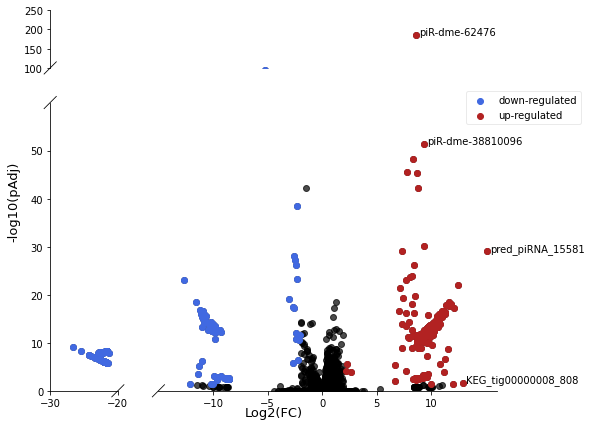

In [7]:
# Volcano plot of significant RNAs
DERs_inf_cur_up = DERs_inf_cur[(DERs_inf_cur["log2FoldChange"] > 2) & (DERs_inf_cur["padj"] < 0.05)]
DERs_inf_cur_down = DERs_inf_cur[(DERs_inf_cur["log2FoldChange"] < -2) & (DERs_inf_cur["padj"] < 0.05)]

fig = plt.figure(figsize=(8,7))
bax = brokenaxes(
    ylims=[(0,60), (100, 250)],
    xlims=[(-30,-20), (-15, 16)],
    height_ratios=[1, 5],
    width_ratios=[0.2, 1]
)
bax.scatter(DERs_inf_cur["log2FoldChange"], -1*np.log10(DERs_inf_cur["padj"]), c="black",alpha=0.7)
bax.scatter(DERs_inf_cur_down["log2FoldChange"],  -1*np.log10(DERs_inf_cur_down["padj"]), c="royalblue",label="down-regulated")
bax.scatter(DERs_inf_cur_up["log2FoldChange"],-1*np.log10(DERs_inf_cur_up["padj"]),c="firebrick", label ="up-regulated")
bax.set_ylabel("-log10(pAdj)", size=13)
bax.set_xlabel("Log2(FC)", size=13)
legend = bax.legend(bbox_to_anchor =(1.2, 0.8))
legend.get_frame().set_alpha(0.4)

for rowname in DERs_inf_cur[(DERs_inf_cur["log2FoldChange"] > 12.5) & (DERs_inf_cur["padj"]< 0.05)].index:
    bax.annotate(rowname, (DERs_inf_cur.loc[rowname,"log2FoldChange"]+0.3,-1*np.log10(DERs_inf_cur.loc[rowname,"padj"])))
for rowname in DERs_inf_cur[-1*np.log10(DERs_inf_cur["padj"]) > 50].index:
    print(rowname)
    bax.annotate(rowname, (DERs_inf_cur.loc[rowname,"log2FoldChange"]+0.3,-1*np.log10(DERs_inf_cur.loc[rowname,"padj"])))

bax.first_col[1].set_yticks([0,10,20,30,40,50])
bax.first_col[0].set_yticks([100,150,200,250])
bax.last_row[0].set_xticks([-30,-20])
bax.last_row[1].set_xticks([-10,-5,0,5,10])
plt.savefig("volcano_plot.pdf", format="pdf",bbox_inches='tight',dpi=100,transparent=True)
plt.savefig("volcano_plot.png", format="png",bbox_inches='tight',dpi=100,transparent=True)
plt.show()


piR-dme-62476
piR-dme-38810096


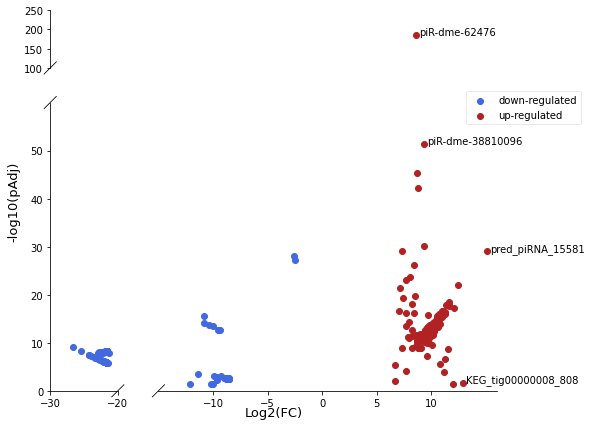

In [8]:
up_masked = removed_noise[(removed_noise["log2FoldChange"] > 2) & (removed_noise["padj"] < 0.05)]
down_masked = removed_noise[(removed_noise["log2FoldChange"] < -2) & (removed_noise["padj"] < 0.05)]

fig = plt.figure(figsize=(8,7))
bax = brokenaxes(
    ylims=[(0,60), (100, 250)],
    xlims=[(-30,-20), (-15, 16)],
    height_ratios=[1, 5],
    width_ratios=[0.2, 1]
)
bax.scatter(down_masked["log2FoldChange"],  -1*np.log10(down_masked["padj"]), c="royalblue",label="down-regulated")
bax.scatter(up_masked["log2FoldChange"],-1*np.log10(up_masked["padj"]),c="firebrick", label ="up-regulated")
bax.set_ylabel("-log10(pAdj)", size=13)
bax.set_xlabel("Log2(FC)", size=13)
legend = bax.legend(bbox_to_anchor =(1.2, 0.8))
legend.get_frame().set_alpha(0.4)

for rowname in up_masked[(up_masked["log2FoldChange"] > 12.5) & (up_masked["padj"]< 0.05)].index:
    bax.annotate(rowname, (up_masked.loc[rowname,"log2FoldChange"]+0.3,-1*np.log10(up_masked.loc[rowname,"padj"])))
for rowname in up_masked[-1*np.log10(up_masked["padj"]) > 50].index:
    print(rowname)
    bax.annotate(rowname, (up_masked.loc[rowname,"log2FoldChange"]+0.3,-1*np.log10(up_masked.loc[rowname,"padj"])))

bax.first_col[1].set_yticks([0,10,20,30,40,50])
bax.first_col[0].set_yticks([100,150,200,250])
bax.last_row[0].set_xticks([-30,-20])
bax.last_row[1].set_xticks([-10,-5,0,5,10])
plt.show()

In [9]:
mapped_wol_301 = list(pd.read_csv("../DEGs_vs_Wolbachia/masked_all_DEGs_mapped_Wol_from_301.txt", index_col=None, comment="@", header = None)[0])
with open("../Merge_ALL_Identified_RNAs/DEGs_Masked_301_Mapped_Wolbachia.fasta","w") as f:
    for i in mapped_wol_301:
        seq = res.loc[i,"Seqs"]
        f.write(f">{i}\n{seq}\n")

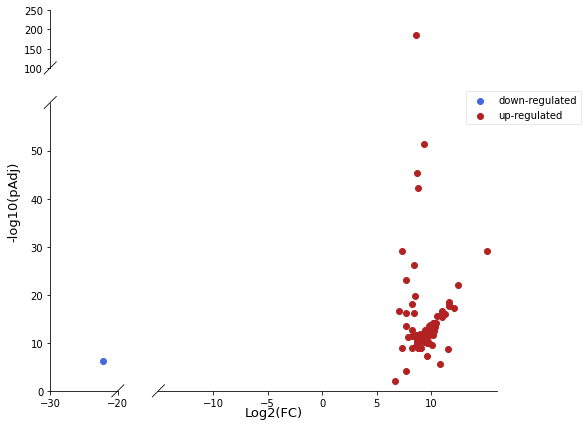

In [10]:
up_in_wol= up_masked[up_masked.index.isin(mapped_wol_301)]
down_in_wol = down_masked[down_masked.index.isin(mapped_wol_301)]
fig = plt.figure(figsize=(8,7))
bax = brokenaxes(
    ylims=[(0,60), (100, 250)],
    xlims=[(-30,-20), (-15, 16)],
    height_ratios=[1, 5],
    width_ratios=[0.2, 1]
)
bax.scatter(down_in_wol["log2FoldChange"],  -1*np.log10(down_in_wol["padj"]), c="royalblue",label="down-regulated")
bax.scatter(up_in_wol["log2FoldChange"],-1*np.log10(up_in_wol["padj"]),c="firebrick", label ="up-regulated")
bax.set_ylabel("-log10(pAdj)", size=13)
bax.set_xlabel("Log2(FC)", size=13)
legend = bax.legend(bbox_to_anchor =(1.2, 0.8))
legend.get_frame().set_alpha(0.4)

bax.first_col[1].set_yticks([0,10,20,30,40,50])
bax.first_col[0].set_yticks([100,150,200,250])
bax.last_row[0].set_xticks([-30,-20])
bax.last_row[1].set_xticks([-10,-5,0,5,10])
plt.show()

In [11]:
pd.set_option("display.max_rows",None)
wol_raw_counts = raw_counts[raw_counts.index.isin(mapped_wol_301)]
display(wol_raw_counts)
 
continues_exp_wol = wol_raw_counts[(wol_raw_counts["KEG"] > 100) & 
                                   (wol_raw_counts["KFC"] > 100) & 
                                   (wol_raw_counts["KMV"] > 100)]
display(continues_exp_wol)

,JEG,JFC,JMV,KEG,KFC,KMV,AEG,AFC,AMV
piR-dme-62476,57.0,18.0,73.0,14853.0,16837.0,22141.0,48.0,24.0,63.0
piR-dme-155190,0.0,0.0,0.0,141.0,259.0,323.0,0.0,0.0,0.0
piR-dme-333803,0.0,3.0,0.0,188.0,221.0,234.0,0.0,0.0,3.0
piR-dme-6258388,0.0,0.0,1.0,168.0,178.0,492.0,0.0,0.0,2.0
piR-dme-7555326,0.0,0.0,5.0,111.0,155.0,408.0,2.0,0.0,0.0
piR-dme-8772583,0.0,0.0,0.0,125.0,95.0,243.0,0.0,0.0,0.0
piR-dme-10714862,0.0,1.0,0.0,107.0,168.0,232.0,0.0,0.0,0.0
piR-dme-11343739,0.0,0.0,0.0,60.0,253.0,249.0,1.0,0.0,0.0
piR-dme-11463543,0.0,0.0,2.0,147.0,166.0,262.0,0.0,4.0,0.0
piR-dme-12199247,1.0,2.0,8.0,833.0,875.0,1529.0,2.0,3.0,2.0


,JEG,JFC,JMV,KEG,KFC,KMV,AEG,AFC,AMV
piR-dme-62476,57.0,18.0,73.0,14853.0,16837.0,22141.0,48.0,24.0,63.0
piR-dme-155190,0.0,0.0,0.0,141.0,259.0,323.0,0.0,0.0,0.0
piR-dme-333803,0.0,3.0,0.0,188.0,221.0,234.0,0.0,0.0,3.0
piR-dme-6258388,0.0,0.0,1.0,168.0,178.0,492.0,0.0,0.0,2.0
piR-dme-7555326,0.0,0.0,5.0,111.0,155.0,408.0,2.0,0.0,0.0
piR-dme-10714862,0.0,1.0,0.0,107.0,168.0,232.0,0.0,0.0,0.0
piR-dme-11463543,0.0,0.0,2.0,147.0,166.0,262.0,0.0,4.0,0.0
piR-dme-12199247,1.0,2.0,8.0,833.0,875.0,1529.0,2.0,3.0,2.0
piR-dme-12294433,0.0,0.0,0.0,108.0,185.0,337.0,0.0,0.0,0.0
piR-dme-12410583,0.0,0.0,0.0,114.0,165.0,352.0,0.0,0.0,6.0


In [12]:
with open("../Merge_ALL_Identified_RNAs/DEGs_301_continues_Mapped_Wolbachia.fasta","w") as f:
    for i in continues_exp_wol.index:
        seq = res.loc[i,"Seqs"]
        f.write(f">{i}\n{seq}\n")

In [13]:
with open("../Merge_ALL_Identified_RNAs/DEGs_Masked_301.fasta","w") as f:
    for i in res.index:
        seq = res.loc[i,"Seqs"]
        f.write(f">{i}\n{seq}\n")

In [14]:
continues_wol_res = res[res.index.isin(list(continues_exp_wol.index))]

In [32]:
continues_wol_res.index.name = "Identifier"
continues_wol_res = continues_wol_res[continues_wol_res.index.isin(mapped_wol_301)]
continues_wol_res["Seqs"] = continues_wol_res["Seqs"].str.replace("T","U")
len(continues_wol_res)

64

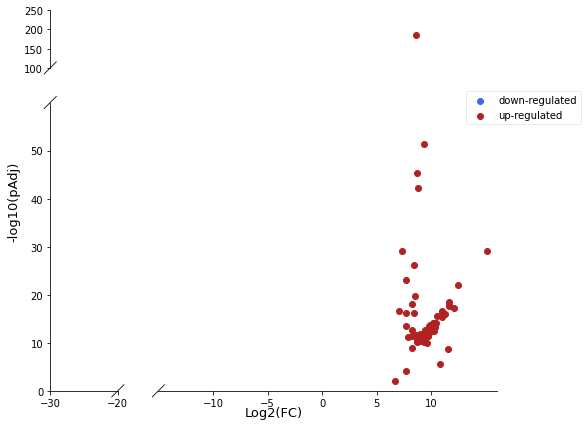

In [16]:
up_in_wol= up_masked[up_masked.index.isin(continues_wol_res.index)]
down_in_wol = down_masked[down_masked.index.isin(continues_wol_res.index)]
fig = plt.figure(figsize=(8,7))
bax = brokenaxes(
    ylims=[(0,60), (100, 250)],
    xlims=[(-30,-20), (-15, 16)],
    height_ratios=[1, 5],
    width_ratios=[0.2, 1]
)
bax.scatter(down_in_wol["log2FoldChange"],  -1*np.log10(down_in_wol["padj"]), c="royalblue",label="down-regulated")
bax.scatter(up_in_wol["log2FoldChange"],-1*np.log10(up_in_wol["padj"]),c="firebrick", label ="up-regulated")
bax.set_ylabel("-log10(pAdj)", size=13)
bax.set_xlabel("Log2(FC)", size=13)
# bax.set_title("Volcano plot indicating differentially expressed RNAs", size="large", weight="bold")
legend = bax.legend(bbox_to_anchor =(1.2, 0.8))
legend.get_frame().set_alpha(0.4)

bax.first_col[1].set_yticks([0,10,20,30,40,50])
bax.first_col[0].set_yticks([100,150,200,250])
bax.last_row[0].set_xticks([-30,-20])
bax.last_row[1].set_xticks([-10,-5,0,5,10])
# plt.tight_layout()
plt.show()

In [17]:
res.index.name = "Identifier"
res = res[res.index.isin(mapped_wol_301)]
res["Seqs"] = res["Seqs"].str.replace("T","U")
res["padj"] = -1*np.log10(res["padj"])
res[["log2FoldChange","padj"]] = res[["log2FoldChange","padj"]].round(4)
res = res.sort_values(by="padj", ascending=False)
cm = sns.cm.vlag
# res = res.sort_values(by="log2FoldChange", key=abs, ascending=False)
res = (res.style
          .background_gradient(cmap=cm,subset="log2FoldChange").set_precision(4)
          .set_properties(**{"text-align":"center"})
          )
res = res.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
res
# dfi.export(res,"DEGs_top20.png")

,log2FoldChange,padj,Seqs,Length
Identifier,,,,
piR-dme-62476,8.6052,185.1543,UGAAAAGAACUGGCAGUUACUGACC,25
piR-dme-38810096,9.3635,51.2676,AACAAGUGGCGUGCCUGUAAAUCAACC,27
piR-dme-35542526,8.7416,45.2616,AACUGAAAAAAUCUGGUGGCUACUGACC,28
piR-dme-12199247,8.7734,42.1685,GAAAAGAACUGGCAGUUACUGACU,24
pred_piRNA_15581,15.1043,29.0902,AAAGAACUGGCAGUUACUGAC,21
piR-dme-34412243,7.3248,29.0274,UAUAGGCAACUCCGGCAGACUAAGAUC,27
piR-dme-33556300,8.4657,26.2383,AAUAGCCAUUUAACUGUUGAAGAAC,25
piR-dme-36713997,7.7152,23.1459,AUAUGUGAUUGCAGUUCGUACAUUUUACC,29
pred_piRNA_20514,12.4262,22.1185,AUGACAUCGUAGGGGUGCUGGCC,23


In [18]:
# Writing all piRNAs and some novel miRNAs not mapped to Wolbachia to fasta for ping-pong finder
All_Seqs[~All_Seqs.index.isin(mapped_wol_301)]
with open("../all_piRNAs_ping_pong.fasta","w") as f:
    for i in All_Seqs.index:
        seq = All_Seqs.loc[i,"Seqs"]
        f.write(f">{i}\n{seq}\n")

In [19]:
# performed blast against genomic transformer
# blastn -subject DEGs_301_continues_Mapped_Wolbachia.fasta -query Tra_Mapping/Ajap_traregion.fas -task "blastn-short" -word_size 10 -outfmt 6 > tra_continues_DE
# Gs_Wol.txt
mapped_tra_10nt = pd.read_csv("../tra_continues_DEGs_Wol.txt", sep ="\s+")
piRNAs_mapping_Tra = list(mapped_tra_10nt["sseqid"])
mapped_tra_10nt

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,tig00000781_traregion,piR-dme-10714862,94.118,17,1,0,9826,9842,3,19,0.15,26.3
1,tig00000781_traregion,piR-dme-35393678,100.000,12,0,0,7645,7656,9,20,0.57,24.3
2,tig00000781_traregion,pred_piRNA_18219,100.000,11,0,0,1607,1617,22,12,2.30,22.3
3,tig00000781_traregion,pred_piRNA_18219,100.000,10,0,0,10851,10860,11,20,9.00,20.3
4,tig00000781_traregion,pred_piRNA_16538,100.000,11,0,0,11162,11172,16,6,2.30,22.3
5,tig00000781_traregion,pred_piRNA_16538,100.000,10,0,0,10510,10519,18,9,9.00,20.3
6,tig00000781_traregion,piR-dme-36942000,100.000,11,0,0,2260,2270,19,9,2.30,22.3
7,tig00000781_traregion,piR-dme-7555326,100.000,11,0,0,7522,7532,12,22,2.30,22.3
8,tig00000781_traregion,piR-dme-7555326,100.000,10,0,0,11310,11319,23,14,9.00,20.3
9,tig00000781_traregion,pred_piRNA_20514,100.000,10,0,0,11730,11739,1,10,9.00,20.3


In [20]:
raw_counts[raw_counts.index.isin(piRNAs_mapping_Tra)]

,JEG,JFC,JMV,KEG,KFC,KMV,AEG,AFC,AMV
piR-dme-7555326,0.0,0.0,5.0,111.0,155.0,408.0,2.0,0.0,0.0
piR-dme-10714862,0.0,1.0,0.0,107.0,168.0,232.0,0.0,0.0,0.0
piR-dme-32758534,0.0,0.0,0.0,113.0,211.0,183.0,0.0,0.0,2.0
piR-dme-33651011,0.0,0.0,1.0,215.0,374.0,368.0,2.0,0.0,1.0
piR-dme-35393678,7.0,0.0,0.0,104.0,111.0,253.0,0.0,0.0,0.0
piR-dme-35542526,2.0,0.0,3.0,913.0,1183.0,1949.0,0.0,1.0,8.0
piR-dme-36942000,0.0,0.0,1.0,182.0,217.0,726.0,1.0,0.0,1.0
piR-dme-41681210,0.0,0.0,0.0,114.0,160.0,327.0,0.0,1.0,0.0
pred_piRNA_16538,0.0,0.0,0.0,136.0,203.0,220.0,0.0,0.0,0.0
pred_piRNA_18219,0.0,0.0,0.0,175.0,218.0,463.0,0.0,0.0,0.0


In [21]:
continues_to_tra = continues_wol_res.loc[piRNAs_mapping_Tra]

In [22]:
print(continues_to_tra.to_latex())

\begin{tabular}{lrrlr}
\toprule
{} &  log2FoldChange &          padj &                            Seqs &  Length \\
Identifier       &                 &               &                                 &         \\
\midrule
piR-dme-10714862 &        9.749669 &  1.222781e-13 &        AAAGCUCGGGAAGACGUGAACAAC &      24 \\
piR-dme-35393678 &        9.624003 &  1.109028e-10 &  UCCAAGUGGAACAAAUGAAGGUUGGAUAAA &      30 \\
pred\_piRNA\_18219 &       10.488980 &  9.664176e-15 &          UAUGAUCUGGAUUCUUUUUAAC &      22 \\
pred\_piRNA\_18219 &       10.488980 &  9.664176e-15 &          UAUGAUCUGGAUUCUUUUUAAC &      22 \\
pred\_piRNA\_16538 &        9.910685 &  2.000401e-14 &           UCAGGACACUGGAAUGACACC &      21 \\
pred\_piRNA\_16538 &        9.910685 &  2.000401e-14 &           UCAGGACACUGGAAUGACACC &      21 \\
piR-dme-36942000 &        9.011342 &  1.251212e-12 &    ACAUAAUCAACCGACUGUAGAAGUAAUA &      28 \\
piR-dme-7555326  &        8.275064 &  1.064448e-09 &    UAAUGUAUCGGCGUCUUAUGUUCAAUU

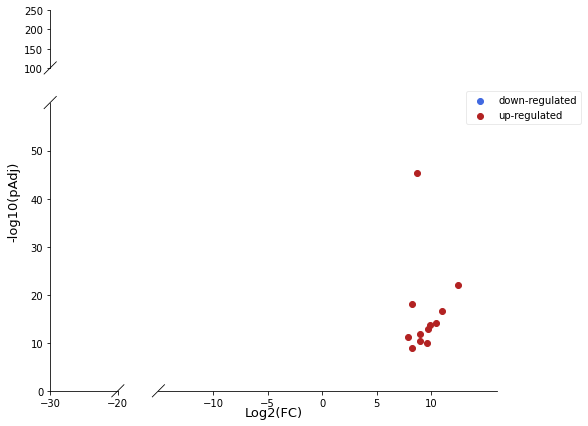

In [23]:
up_in_wol= up_masked[up_masked.index.isin(piRNAs_mapping_Tra)]
down_in_wol = down_masked[down_masked.index.isin(piRNAs_mapping_Tra)]
fig = plt.figure(figsize=(8,7))
bax = brokenaxes(
    ylims=[(0,60), (100, 250)],
    xlims=[(-30,-20), (-15, 16)],
    height_ratios=[1, 5],
    width_ratios=[0.2, 1]
)
bax.scatter(down_in_wol["log2FoldChange"],  -1*np.log10(down_in_wol["padj"]), c="royalblue",label="down-regulated")
bax.scatter(up_in_wol["log2FoldChange"],-1*np.log10(up_in_wol["padj"]),c="firebrick", label ="up-regulated")
bax.set_ylabel("-log10(pAdj)", size=13)
bax.set_xlabel("Log2(FC)", size=13)
legend = bax.legend(bbox_to_anchor =(1.2, 0.8))
legend.get_frame().set_alpha(0.4)

bax.first_col[1].set_yticks([0,10,20,30,40,50])
bax.first_col[0].set_yticks([100,150,200,250])
bax.last_row[0].set_xticks([-30,-20])
bax.last_row[1].set_xticks([-10,-5,0,5,10])
plt.show()

In [24]:
print(mapped_tra_10nt[["sseqid","pident","length","mismatch", "gapopen","qstart","qend","sstart","send"]].to_latex(index=False))

\begin{tabular}{lrrrrrrrr}
\toprule
          sseqid &  pident &  length &  mismatch &  gapopen &  qstart &  qend &  sstart &  send \\
\midrule
piR-dme-10714862 &  94.118 &      17 &         1 &        0 &    9826 &  9842 &       3 &    19 \\
piR-dme-35393678 & 100.000 &      12 &         0 &        0 &    7645 &  7656 &       9 &    20 \\
pred\_piRNA\_18219 & 100.000 &      11 &         0 &        0 &    1607 &  1617 &      22 &    12 \\
pred\_piRNA\_18219 & 100.000 &      10 &         0 &        0 &   10851 & 10860 &      11 &    20 \\
pred\_piRNA\_16538 & 100.000 &      11 &         0 &        0 &   11162 & 11172 &      16 &     6 \\
pred\_piRNA\_16538 & 100.000 &      10 &         0 &        0 &   10510 & 10519 &      18 &     9 \\
piR-dme-36942000 & 100.000 &      11 &         0 &        0 &    2260 &  2270 &      19 &     9 \\
 piR-dme-7555326 & 100.000 &      11 &         0 &        0 &    7522 &  7532 &      12 &    22 \\
 piR-dme-7555326 & 100.000 &      10 &         0 &      

In [25]:
print(mapped_tra_10nt.to_latex(index=False))

\begin{tabular}{llrrrrrrrrrr}
\toprule
               qseqid &           sseqid &  pident &  length &  mismatch &  gapopen &  qstart &  qend &  sstart &  send &  evalue &  bitscore \\
\midrule
tig00000781\_traregion & piR-dme-10714862 &  94.118 &      17 &         1 &        0 &    9826 &  9842 &       3 &    19 &    0.15 &      26.3 \\
tig00000781\_traregion & piR-dme-35393678 & 100.000 &      12 &         0 &        0 &    7645 &  7656 &       9 &    20 &    0.57 &      24.3 \\
tig00000781\_traregion & pred\_piRNA\_18219 & 100.000 &      11 &         0 &        0 &    1607 &  1617 &      22 &    12 &    2.30 &      22.3 \\
tig00000781\_traregion & pred\_piRNA\_18219 & 100.000 &      10 &         0 &        0 &   10851 & 10860 &      11 &    20 &    9.00 &      20.3 \\
tig00000781\_traregion & pred\_piRNA\_16538 & 100.000 &      11 &         0 &        0 &   11162 & 11172 &      16 &     6 &    2.30 &      22.3 \\
tig00000781\_traregion & pred\_piRNA\_16538 & 100.000 &      10 &      

In [26]:
# Extracting all interesting piRNAs mapping in exons.

exon_m1 = [6741,7895]
exon_m2 = [7896,9568]
indexes_of_interest = []
for i in mapped_tra_10nt.index:
    if (mapped_tra_10nt.loc[i,"qstart"] >= 6741) & (mapped_tra_10nt.loc[i,"qend"] <= 7895):
        indexes_of_interest.append(i)
    if (mapped_tra_10nt.loc[i,"qstart"] >= 7896) & (mapped_tra_10nt.loc[i,"qend"] <= 9568):
        indexes_of_interest.append(i)
mapped_in_exon = mapped_tra_10nt.iloc[indexes_of_interest]
mapped_in_exon.to_csv(sep="\t")
potential_candidates = All_Seqs.loc[list(mapped_in_exon["sseqid"]),"Seqs"]

with open("piRNAs_in_interesting_exon.fasta","w") as f:
    for i in mapped_in_exon["sseqid"]:
            seq = All_Seqs.loc[i,"Seqs"]
            f.write(f">{i}\n{seq}\n")

In [27]:
print(mapped_in_exon[["sseqid","pident","length","mismatch", "gapopen","qstart","qend","sstart","send"]].to_latex(index=False))

\begin{tabular}{lrrrrrrrr}
\toprule
          sseqid &  pident &  length &  mismatch &  gapopen &  qstart &  qend &  sstart &  send \\
\midrule
piR-dme-35393678 &   100.0 &      12 &         0 &        0 &    7645 &  7656 &       9 &    20 \\
 piR-dme-7555326 &   100.0 &      11 &         0 &        0 &    7522 &  7532 &      12 &    22 \\
piR-dme-35542526 &   100.0 &      10 &         0 &        0 &    8648 &  8657 &       5 &    14 \\
piR-dme-33651011 &   100.0 &      10 &         0 &        0 &    8946 &  8955 &      14 &    23 \\
piR-dme-33651011 &   100.0 &      10 &         0 &        0 &    8230 &  8239 &      19 &    28 \\
\bottomrule
\end{tabular}



In [28]:
continues_wol_res.loc[list(np.unique(potential_candidates.index))]

,log2FoldChange,padj,Seqs,Length
Identifier,,,,
piR-dme-33651011,8.246228,7.285748e-19,GAGAACCGGAUUUUGAUACUCCAGAUCAUA,30
piR-dme-35393678,9.624003,1.109028e-10,UCCAAGUGGAACAAAUGAAGGUUGGAUAAA,30
piR-dme-35542526,8.741640,5.474737e-46,AACUGAAAAAAUCUGGUGGCUACUGACC,28
piR-dme-7555326,8.275064,1.064448e-09,UAAUGUAUCGGCGUCUUAUGUUCAAUUU,28


In [29]:
print(continues_wol_res.loc[list(np.unique(potential_candidates.index)),"Seqs"].to_latex(index=True))

\begin{tabular}{ll}
\toprule
{} &                            Seqs \\
Identifier       &                                 \\
\midrule
piR-dme-33651011 &  GAGAACCGGAUUUUGAUACUCCAGAUCAUA \\
piR-dme-35393678 &  UCCAAGUGGAACAAAUGAAGGUUGGAUAAA \\
piR-dme-35542526 &    AACUGAAAAAAUCUGGUGGCUACUGACC \\
piR-dme-7555326  &    UAAUGUAUCGGCGUCUUAUGUUCAAUUU \\
\bottomrule
\end{tabular}



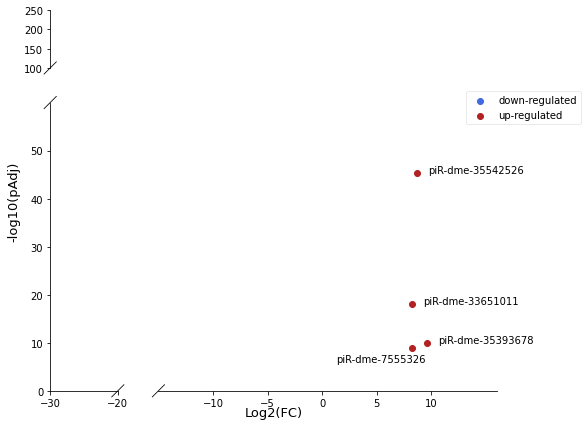

In [30]:
up_in_wol= up_masked[up_masked.index.isin(potential_candidates.index)]
down_in_wol = down_masked[down_masked.index.isin(potential_candidates.index)]
fig = plt.figure(figsize=(8,7))
bax = brokenaxes(
    ylims=[(0,60), (100, 250)],
    xlims=[(-30,-20), (-15, 16)],
    height_ratios=[1, 5],
    width_ratios=[0.2, 1]
)
bax.scatter(down_in_wol["log2FoldChange"],  -1*np.log10(down_in_wol["padj"]), c="royalblue",label="down-regulated")
bax.scatter(up_in_wol["log2FoldChange"],-1*np.log10(up_in_wol["padj"]),c="firebrick", label ="up-regulated")
bax.set_ylabel("-log10(pAdj)", size=13)
bax.set_xlabel("Log2(FC)", size=13)
for rowname in up_in_wol.index:
    if rowname == "piR-dme-7555326":
        bax.annotate(rowname, (up_in_wol.loc[rowname,"log2FoldChange"]-7,((-1*np.log10(up_in_wol.loc[rowname,"padj"])-3))))
    else:
        bax.annotate(rowname, (up_in_wol.loc[rowname,"log2FoldChange"]+1,-1*np.log10(up_in_wol.loc[rowname,"padj"])))

legend = bax.legend(bbox_to_anchor =(1.2, 0.8))
legend.get_frame().set_alpha(0.4)

bax.first_col[1].set_yticks([0,10,20,30,40,50])
bax.first_col[0].set_yticks([100,150,200,250])
bax.last_row[0].set_xticks([-30,-20])
bax.last_row[1].set_xticks([-10,-5,0,5,10])
# plt.tight_layout()
plt.show()

In [31]:
wol_not_tra = continues_exp_wol[~continues_exp_wol.index.isin(piRNAs_mapping_Tra)]
with open("../Merge_ALL_Identified_RNAs/Wol_Mapped_Tra_mapped_removed.fasta","w") as f:
    for i in wol_not_tra.index:
        seq =  All_Seqs.loc[i,"Seqs"]
        f.write(f">{i}\n{seq}\n")